<a href="https://colab.research.google.com/github/dadang6842/AI-study/blob/main/assignments/HAR_LSTM_CNN_250731.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- https://medium.com/@tanmaychauhan111/human-activity-recognition-using-lstm-cnn-8ccb1a42cb81
- 위 블로그 참고하여 코드 작성

LSTM + CNN이 CNN only model보다 성능이 낮게 나오는 이유?
- return_sequences=True: 출력 시퀀스가 커짐 -> overfitting 유발
- LSTM은 데이터 수가 적은 라벨을 제대로 학습하지 못함 -> 반복되는 시퀀스가 적고 LSTM의 파라미터 수에 비해 너무 적은 예제를 제공하기 때문
- 반면 CNN은 국소 특징 중심이라 상대적으로 불균형에 덜 민감

HAR_LSTM_CNN_250729.ipynb와의 차이
- 클래스 불균형 보정: class_weight 설정
- 모델 구조 단순화: LSTM을 1개로 축소
- LSTM의 입력을 (batch, time_steps * features, 1)로 reshape하던 것을 (batch, time_steps, features)로 변경 -> LSTM은 3D 입력을 받기 때문
- reshape할 때 float64 -> float32로 변경
- 배치 사이즈를 192에서 64로 축소 -> 큰 배치는 안정적이지만 평균화 강함, 작은 배치는 미묘한 패턴을 잘 보존
- early stopping, validation 적용

결과
- 이전보다는 성능이 향상되었지만 여전히 데이터가 부족한 클래스는 잘 분류되지 않음
- CNN -> LSTM 구조 시도해보기

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, MaxPool1D, GlobalAveragePooling1D, BatchNormalization, Dense, Activation
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
names = ["user_id", "activity", "timestamp", "x_axis", "y_axis", "z_axis", "NaN"]
data = pd.read_csv("/content/drive/MyDrive/AI_data/WISDM_ar_v1.1_raw.txt", header=None, names=names, comment=";") # comment -> ;로 시작하는 줄 무시(주석)


In [3]:
def convert_to_float(x):
    try:
        return float(x)
    except:
        return np.nan

In [4]:
df = data.drop('NaN', axis=1)
df.isna().sum()

,0
user_id,0
activity,0
timestamp,0
x_axis,0
y_axis,0
z_axis,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1098204 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1098204 non-null  int64  
 1   activity   1098204 non-null  object 
 2   timestamp  1098204 non-null  int64  
 3   x_axis     1098204 non-null  float64
 4   y_axis     1098204 non-null  float64
 5   z_axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 50.3+ MB


In [6]:
df["z_axis"] = df["z_axis"].replace(regex=True, to_replace=r';', value=r'')
df["z_axis"] = df["z_axis"].apply(convert_to_float)
df.dropna(axis=0, how='any', inplace=True) # 하나라도 NaN이 있으면 행을 삭제
df.head()

,user_id,activity,timestamp,x_axis,y_axis,z_axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [7]:
df['activity'].value_counts()

,count
activity,
Walking,424397
Jogging,342176
Upstairs,122869
Downstairs,100427
Sitting,59939
Standing,48395


In [8]:
df['user_id'].value_counts()

,count
user_id,
20,56632
19,45383
31,44282
8,41188
29,38245
14,38192
13,37093
34,35947
32,35506


In [9]:
# Label Encoding
label_encoder = LabelEncoder()
df['activity_encoded'] = label_encoder.fit_transform(df['activity'])
num_classes = len(label_encoder.classes_)
df

,user_id,activity,timestamp,x_axis,y_axis,z_axis,activity_encoded
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953,1
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424,1
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722,1
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717,1
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164,1
...,...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000,2
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000,2
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000,2
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000,2


In [10]:
# label_encoder 매핑 결과 보기
dict(enumerate(label_encoder.classes_))

{0: 'Downstairs',
 1: 'Jogging',
 2: 'Sitting',
 3: 'Standing',
 4: 'Upstairs',
 5: 'Walking'}

In [11]:
# Data Split
df_test = df[df['user_id'] > 30]
df_train = df[df['user_id'] <= 30]

In [12]:
# 정규화
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_train.loc[:, ['x_axis', 'y_axis', 'z_axis']] = scaler.fit_transform(df_train.loc[:, ['x_axis', 'y_axis', 'z_axis']])
# test 셋에서 train에서 학습한 scaler 사용
df_test.loc[:, ['x_axis', 'y_axis', 'z_axis']] = scaler.transform(df_test.loc[:, ['x_axis', 'y_axis', 'z_axis']])

Segmentation
- 슬라이딩 윈도우 방식
- 데이터를 time_steps만큼 자르고 step 간격으로 이동
- 해당 구간에서 가장 많이 나타난 label을 출력값으로 저장
- 결과적으로 딥러닝 모델에 넣을 수 있는 3차원 입력 데이터와 라벨 벡터를 생성
- 3차원 입력 데이터: (샘플 수, 한 샘플이 가지는 시간 길이, feature 개수)

In [13]:
def create_dataset(x, y, time_steps=200, step=40):
    xs, ys = [], []
    for i in range(0, len(x) - time_steps, step):
        v = x.iloc[i:i + time_steps].values
        labels = y.iloc[i:i + time_steps]
        values, counts = np.unique(labels, return_counts=True)
        mode_label = values[np.argmax(counts)]
        xs.append(v)
        ys.append(mode_label)
    return np.array(xs), np.array(ys)

TIME_STEPS = 200
STEP = 40
x_train, y_train = create_dataset(df_train[['x_axis', 'y_axis', 'z_axis']], df_train['activity_encoded'], TIME_STEPS, STEP)
x_test, y_test = create_dataset(df_test[['x_axis', 'y_axis', 'z_axis']], df_test['activity_encoded'], TIME_STEPS, STEP)

reshape
- LSTM 모델에 들어갈 형식으로 reshape
- 연산량을 줄이기 위해 float32로 타입 변경

In [14]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 3)).astype('float32')
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 3)).astype('float32')

In [15]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (22454, 200, 3)
y_train shape: (22454,)
x_test shape: (4992, 200, 3)
y_test shape: (4992,)


class_weight
- 다수 클래스의 학습 기여도는 줄이고, 소수 클래스의 손실에 더 높은 가중치를 주는 방식

In [16]:
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(weights))
print(class_weights_dict)

{0: np.float64(1.8044037287045966), 1: np.float64(0.5433909297710663), 2: np.float64(3.285630670178519), 3: np.float64(3.9145746164574615), 4: np.float64(1.4595683827353094), 5: np.float64(0.42362840540336577)}


In [17]:
# early stopping 콜백 정의
early_stop = EarlyStopping(
    monitor='val_loss',      # 모니터할 지표 (val_accuracy 로도 가능)
    patience=5,              # 개선이 없을 때 기다릴 에포크 수
    restore_best_weights=True  # 최저 val_loss 가 나타난 시점의 가중치 복원
)

In [18]:
# One-Hot Encoding
y_train_hot = to_categorical(y_train, num_classes)
y_test_hot = to_categorical(y_test, num_classes)

In [19]:
# 모델 정의
# LSTM layer 1개로 변경
model = Sequential()
model.add(LSTM(32, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]), activation='relu'))

# LSTM 출력: (batch_size, time_steps, 32)
# Conv1D를 바로 사용 가능하므로 Reshape 생략 가능

model.add(Conv1D(filters=64, kernel_size=2, activation='relu', strides=2))
model.add(MaxPool1D(pool_size=4, padding='same'))
model.add(Conv1D(filters=192, kernel_size=2, activation='relu', strides=1))
model.add(GlobalAveragePooling1D())
model.add(BatchNormalization(epsilon=1e-06)) # epsilon: 0으로 나누는 오류를 방지하기 위한 아주 작은 수
model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 200, 32)        │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 100, 64)        │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 25, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 24, 192)        │        24,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 192)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 192)            │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         1,158 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 6)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,462 (138.52 KB)

 Trainable params: 35,078 (137.02 KB)

 Non-trainable params: 384 (1.50 KB)

In [20]:
# 컴파일 및 학습
# 배치 크기 192 -> 64로 조정
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, y_train_hot, batch_size= 64, epochs=50, class_weight=class_weights_dict, validation_split=0.2, callbacks=[early_stop])

Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.6203 - loss: 0.9552 - val_accuracy: 0.0639 - val_loss: 2.0662
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 15s 18ms/step - accuracy: 0.8501 - loss: 0.4232 - val_accuracy: 0.0635 - val_loss: 2.2670
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.8887 - loss: 0.3241 - val_accuracy: 0.5251 - val_loss: 1.0815
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9118 - loss: 0.2794 - val_accuracy: 0.4542 - val_loss: 2.0285
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9248 - loss: 0.2509 - val_accuracy: 0.8007 - val_loss: 0.9518
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9401 - loss: 0.1986 - val_accuracy: 0.3919 - val_loss: 3.3444
Epoch 7/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9404 - loss: 0.2049 - val_accuracy: 0.8152 - val_loss: 0.8249
Epoch 8/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.9484 - loss: 0.1772 - val_a

- history.history 안에 loss, accuracy 등 에포크 별 기록이 담겨 있음

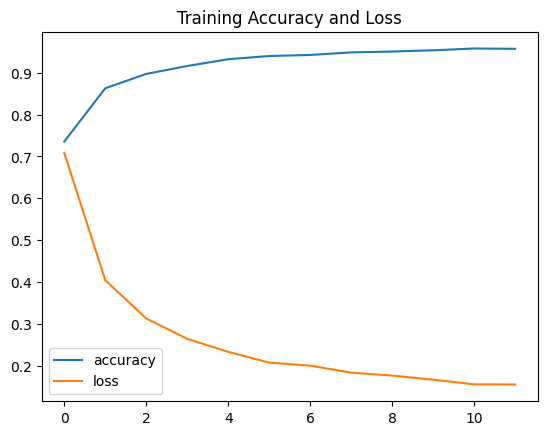

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.title('Training Accuracy and Loss')
plt.show()

In [22]:
score = model.evaluate(x_test, y_test_hot)
print("Test Accuracy:", score[1])
print("Test Loss:", score[0])

156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8599 - loss: 0.4547
Test Accuracy: 0.8559695482254028
Test Loss: 0.4103030562400818


In [23]:
y_pred = np.argmax(model.predict(x_test), axis=1)
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

  Downstairs       0.91      0.52      0.66       446
     Jogging       0.97      0.96      0.96      1669
     Sitting       0.93      0.99      0.96       354
    Standing       0.99      0.77      0.87       252
    Upstairs       0.74      0.26      0.38       500
     Walking       0.76      1.00      0.86      1771

    accuracy                           0.86      4992
   macro avg       0.88      0.75      0.78      4992
weighted avg       0.86      0.86      0.84      4992



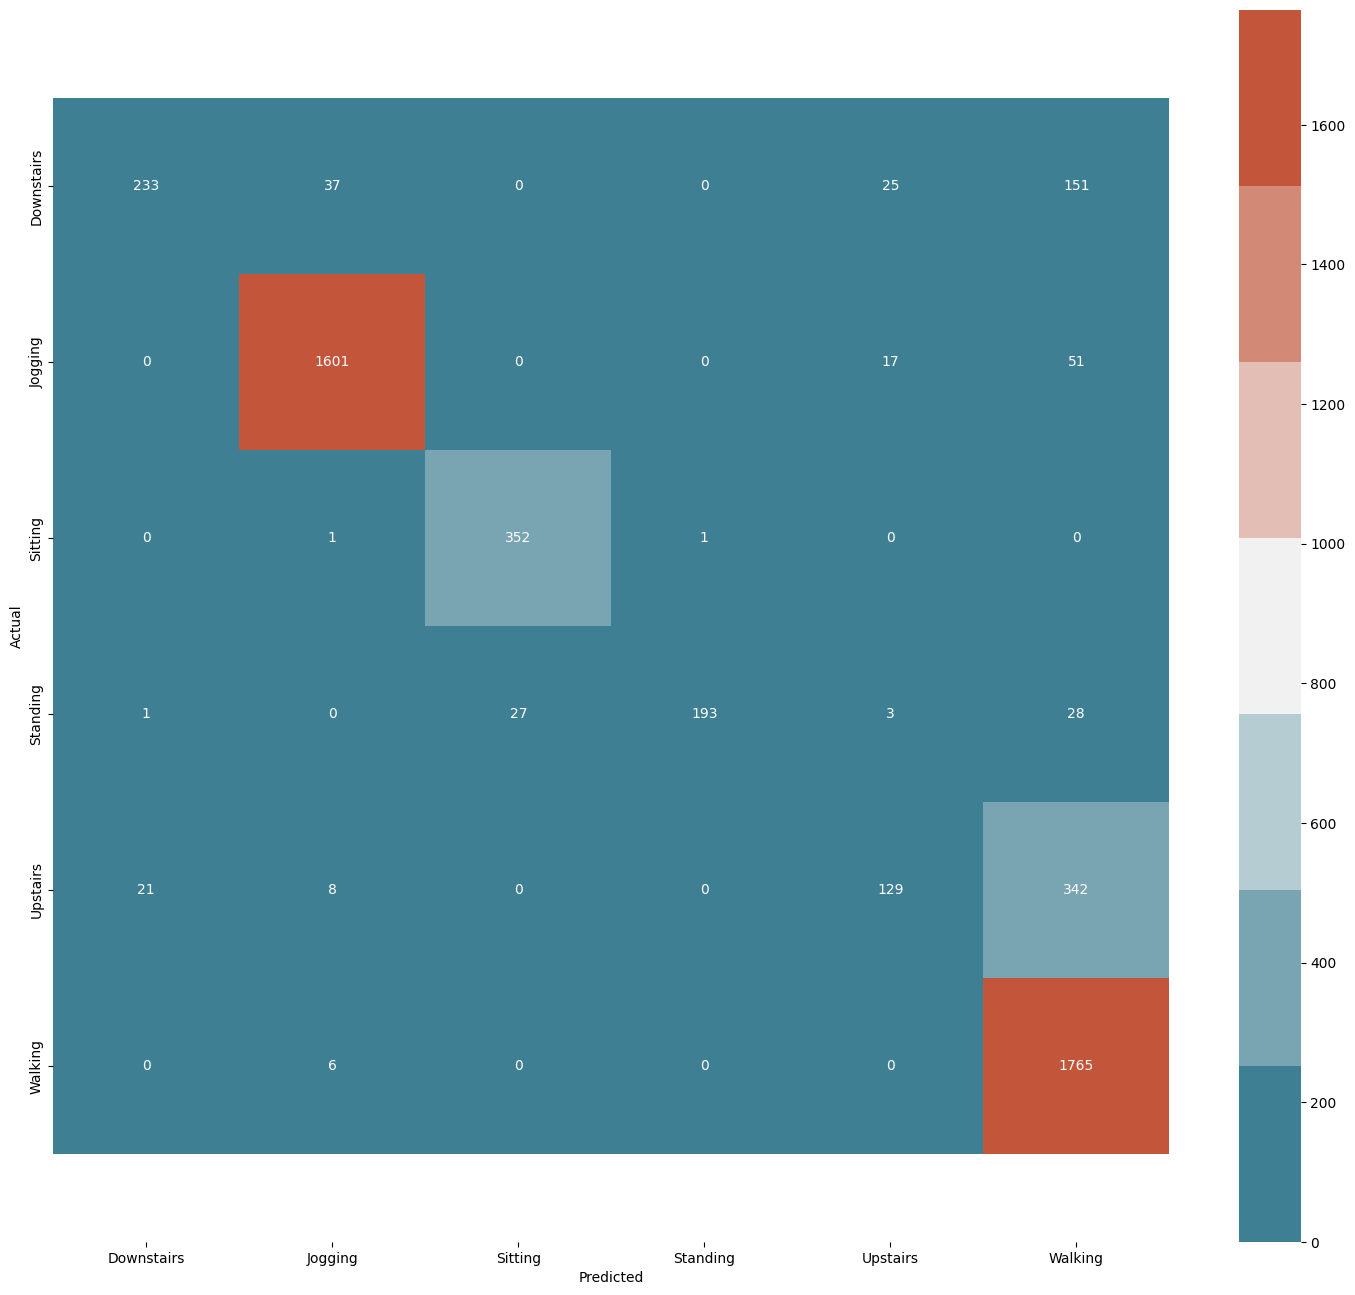

In [24]:
# y_true, y_pred는 정수 label
def plot_cm(y_true, y_pred, class_names):
  cm = confusion_matrix(y_true, y_pred)
  fig, ax = plt.subplots(figsize=(18, 16))
  ax = sns.heatmap(cm, annot=True, fmt="d", cmap = sns.diverging_palette(220, 20, n=7), ax=ax)

  plt.ylabel("Actual")
  plt.xlabel("Predicted")
  ax.set_xticklabels(class_names) # x축에 클래스 이름 부여
  ax.set_yticklabels(class_names) # y축에 클래스 이름 부여
  b, t = plt.ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  plt.ylim(b, t) # update the ylim(bottom, top) values
  plt.show()

plot_cm(y_test, y_pred, label_encoder.classes_)